In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
#import seaborn as sns
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data" / "xx"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
# def modified_disorder_mean(arr,distance_matrix):
#     N = arr.shape[1]
#     SHOTS = arr.shape[2]
#     n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
#     new_arr = np.zeros((arr.shape[0],n_bins))
#     counts = np.zeros(n_bins)
#     for shot in range(0,SHOTS):
#         for j in range(0,N):
#             j_eff= int(distance_matrix[0,j,shot])
#             new_arr[:,j_eff] += arr[:,j,shot]
#             counts[j_eff] += 1
#     for bin in range(0,n_bins):
#         if counts[bin] != 0:
#             new_arr[:,bin] = new_arr[:,bin]/counts[bin]
#     return new_arr

# def count_bins(distance_matrix):
#     N = distance_matrix.shape[0]
#     SHOTS = distance_matrix.shape[2]
#     n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
#     counts = np.zeros(n_bins)
#     for shot in range(0,SHOTS):
#         for j in range(0,N):
#             j_eff= int(distance_matrix[0,j,shot])
#             counts[j_eff] += 1
#     return counts

In [5]:
def modified_disorder_mean(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1 #Bins [0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def count_bins_total(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1 #Bins [0,l),[l,2l),...
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff] += 1
    return counts

In [6]:
def bin_data(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1 #Bins [0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins,SHOTS))
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff,shot] += arr[:,j,shot]
            counts[j_eff,shot] += 1
        for bin in range(0,n_bins):
            if counts[bin,shot] != 0:
                new_arr[:,bin,shot] = new_arr[:,bin,shot]/counts[bin,shot]
    return new_arr

def count_bins(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix)/bin_length)+1 #Bins [0,l),[l,2l),...
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff,shot] += 1
    return counts

In [7]:
positions[0][:,1]

NameError: name 'positions' is not defined

In [8]:
distance_matrices[0][:,:,1][0,-1]

NameError: name 'distance_matrices' is not defined

In [9]:
k = 1
plt.plot(np.mean(bin_data(data[k],distance_matrices[k],1.1),axis=2)[:,:])

NameError: name 'data' is not defined

In [10]:
(count_bins(distance_matrices[1],1.0))[:,5]#,axis=1)

NameError: name 'distance_matrices' is not defined

In [11]:
counts[3]

NameError: name 'counts' is not defined

In [12]:
def logrange(min_exp,max_exp,max):
    res = np.concatenate(([0],[i*10.0**j for j in range(min_exp,max_exp+1) for i in range(1,10)]))
    res = res[res <= max]
    return res

In [13]:
N = 13
SHOTS = 100
T = logrange(-2,10,1e10)

In [14]:
jobids = []
params = []
data = []
positiondesc = []
positions = []
distance_matrices = []
N = 16
folders = [datapath/"noisy_chain_pbc_1.9",datapath/"noisy_chain_pbc_1.4",datapath/"noisy_chain_pbc_1.0",datapath/"noisy_chain_pbc_0.8",datapath/"box_pbc_0.8",datapath/"box_pbc_0.5",datapath/"box_pbc_0.1"]
filename = "combined_file.jld2"
for i in range(len(folders)):
    with h5py.File(folders[i]/filename,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([rearrange_data(f[f["data"][l]]) for l in range(len(f["data"]))]))
        params.append(list(f[f["params"][l]][()] for l in range(len(f["params"]))))

        positiondesc.append(list(f[f["positiondata"][l]][()][0] for l in range(len(f["params"]))))

        positions.append(list(np.swapaxes(f[f[f["positiondata"][l]][()][1]][()],0,1) for l in range(len(f["params"]))))
        distance_matrices.append(list(np.swapaxes(f[f[f["positiondata"][l]][()][2]][()],0,2) for l in range(len(f["params"]))))
for  i in range(0,len(folders)):
        data[i] = np.concatenate(data[i],axis=2)
        positions[i] = np.concatenate(tuple(positions[i][k] for k in range(len(positions[i]))),axis=1)
        distance_matrices[i] = np.concatenate(tuple(distance_matrices[i][k] for k in range(len(distance_matrices[i]))),axis=2)
SHOTS = 100

In [49]:
J = np.power(distance_matrices[1],-6)[:,:,:]

/tmp/ipykernel_100382/310298726.py:1: RuntimeWarning: divide by zero encountered in power
  J = np.power(distance_matrices[1],-6)[:,:,:]


In [56]:
Jm=np.mean([np.median(J[:,:,i].diagonal(1)) for i in range(0,100)])

In [15]:
#res = list(map(lambda arr: symmetrize(disorder_mean(arr)),data))
#res_err = list(map(lambda arr: symmetrize(disorder_std(arr)),data))
#res = list(map(lambda arr: disorder_mean(arr),data))
#res_err = list(map(lambda arr: disorder_std(arr),data))

In [16]:
l = 1.3
res_m = list(map(lambda arr,distance_matrix: modified_disorder_mean(arr,distance_matrix,l), data, distance_matrices))
counts = list(map(lambda distance_matrix: count_bins(distance_matrix,l),distance_matrices))

In [17]:
res_m[1].shape

(110, 8)

In [18]:
positiondesc[0][0]

(b'noisy_chain_pbc', 13, 50, 1.9)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (13,) and arg 1 with shape (13, 100).

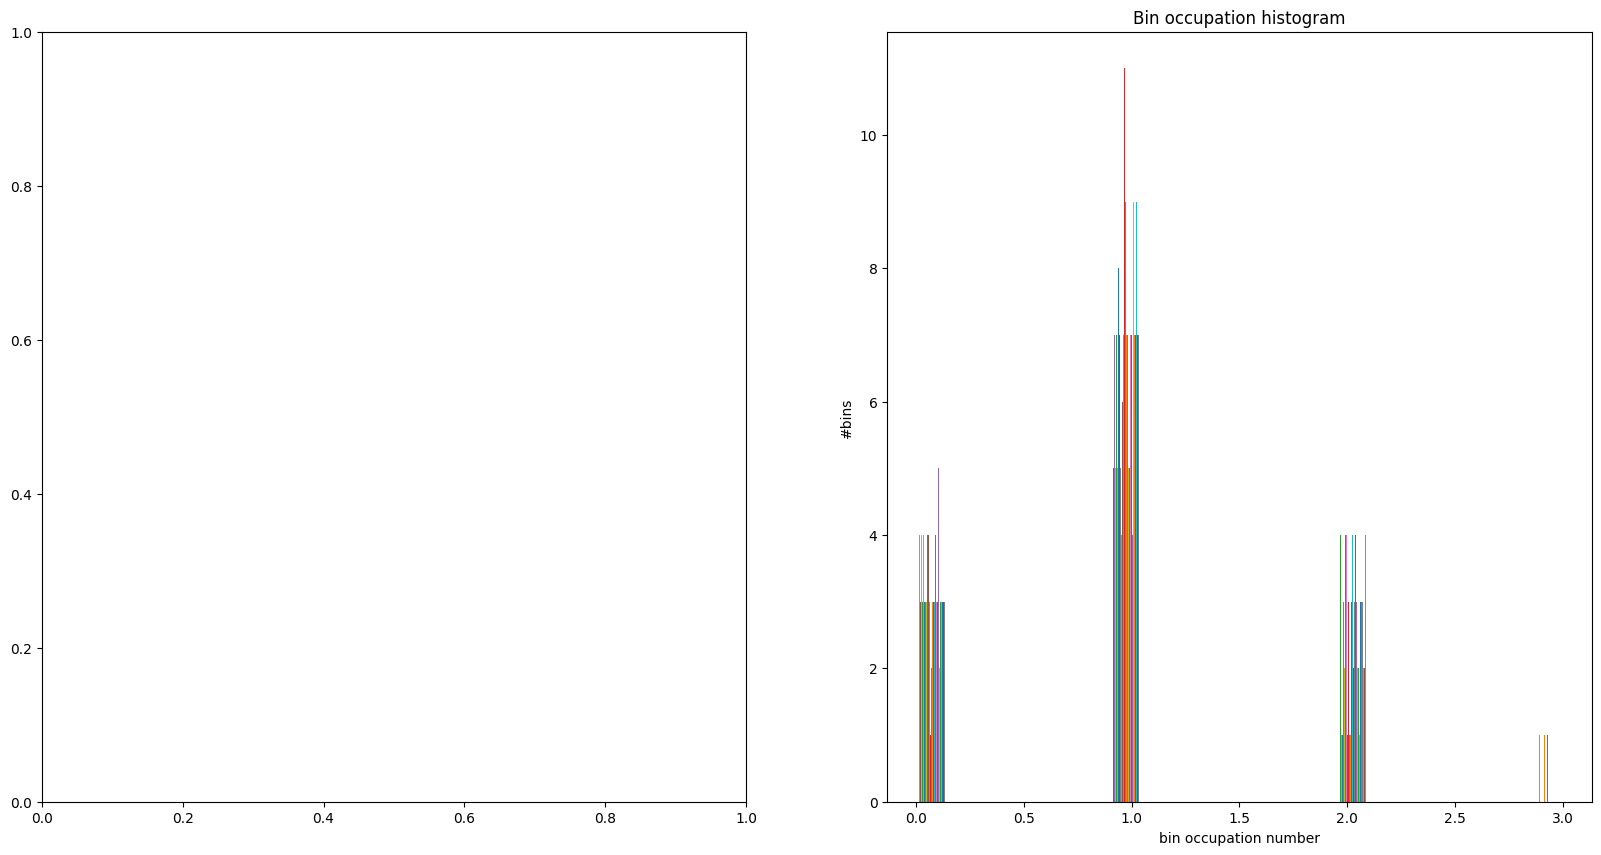

In [19]:
ds=3
bins = [i for i in range(0,len(counts[ds]))]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[1].hist(counts[ds],20)
axs[1].set_title("Bin occupation histogram")
axs[1].set_xlabel("bin occupation number")
axs[1].set_ylabel("#bins")

axs[0].bar(bins,counts[ds])
axs[0].set_title("Occupation of each bin")
axs[0].set_xlabel("r")
axs[0].set_ylabel("occupation")
plt.suptitle(r"Binning disordered distances, bin length: {}; geometry:{}, $\rho=${}".format(l,positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
plt.show()


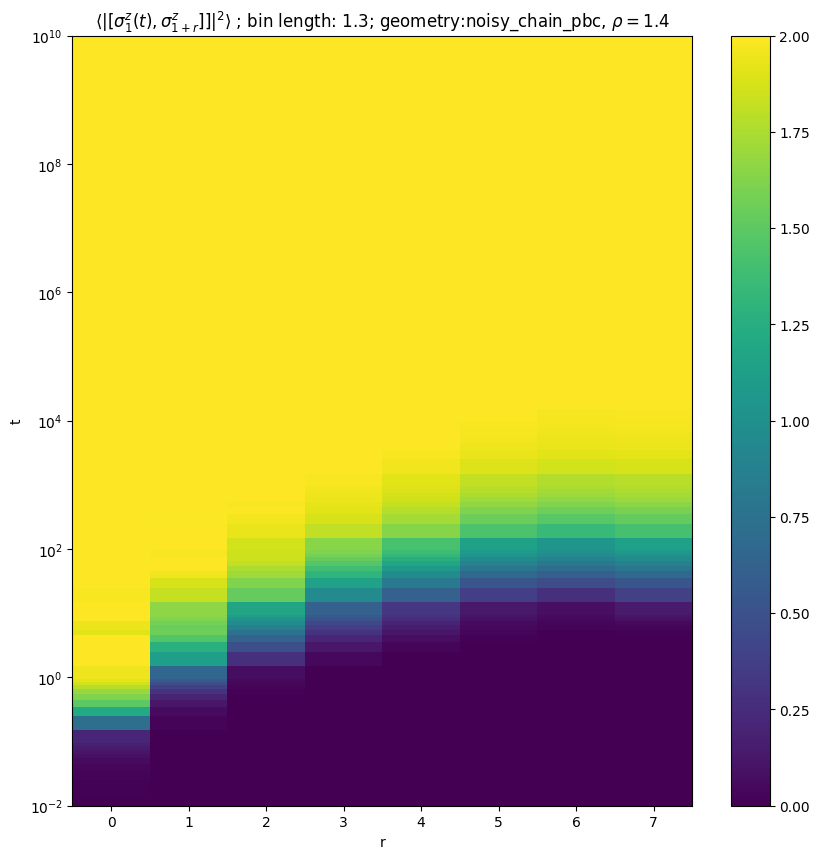

In [ ]:
ds=1
bins = [i for i in range(0,len(counts[ds]))]

x = range(0,len(bins))
y = T
fig, ax = plt.subplots(figsize=(10,10))
ax.set_yscale('log')
im = ax.pcolormesh(x,y,res_m[ds],clim=(0,2))
fig.colorbar(im,ax=ax)
ax.autoscale('tight')
ax.set_ylim(1e-2,1e10)
ax.set_title(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$"+r" ; bin length: {}; geometry:{}, $\rho=${}".format(l,positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
ax.set_xlabel("r")
ax.set_ylabel("t")
plt.show()

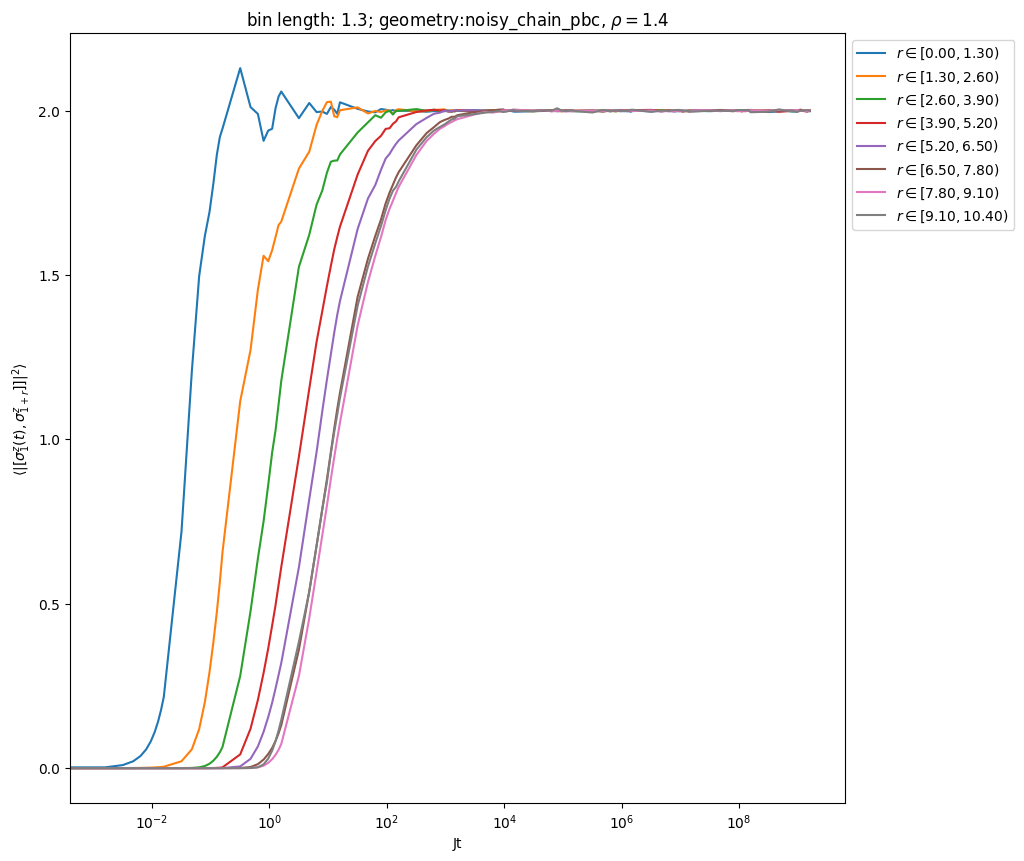

In [57]:
ds=1
bins = [i for i in range(0,len(counts[ds]))]
plt.figure(figsize=(10,10))
for j in range(0,len(bins)):
    plt.semilogx(Jm*T,res_m[ds][:,j],label=r"$r\in[${:.2f}$,${:.2f}$)$".format(j*l,(j+1)*l))
plt.legend()
plt.title(r"bin length: {}; geometry:{}, $\rho=${}".format(l,positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
plt.xlabel("Jt")
plt.ylabel(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$")
plt.legend(bbox_to_anchor=(1, 1))
#plt.xlim(0.01,1e5)
plt.show()

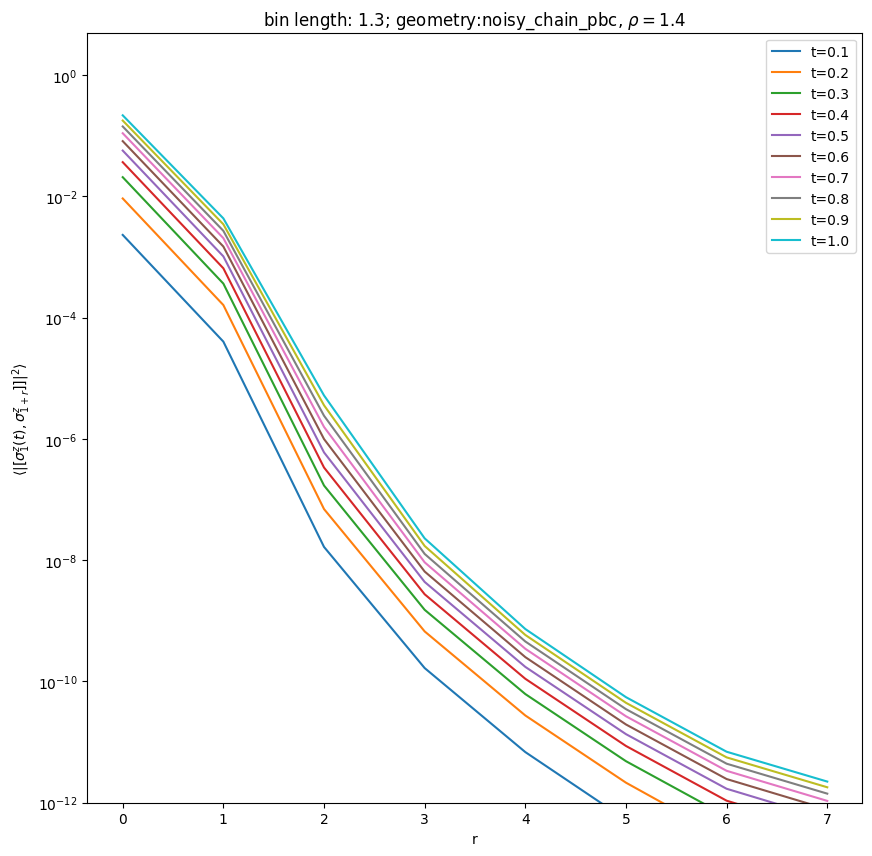

In [136]:
ds = 1
bins = [i for i in range(0,len(counts[ds]))]
fig = plt.figure(figsize=(10,10))
for t in range(1,11,1):
    plt.semilogy(range(0,len(bins)),res_m[ds][t,:],label="t={:.1f}".format(t*0.1))
plt.legend(loc="lower right")
plt.xlabel("r")
plt.ylabel(r"$\langle\left|\left[\sigma_1^z(t),\sigma_{1+r}^z]\right]\right|^2\rangle$")
plt.ylim(1e-12,5)
plt.legend(bbox_to_anchor=(1, 1))
plt.title(r"bin length: {}; geometry:{}, $\rho=${}".format(l,positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
plt.show()